In [2]:
import torch
from transformers import FuyuForCausalLM, AutoTokenizer, FuyuProcessor, FuyuImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import csv
import glob
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
from natsort import natsorted

/home/aih/luca.schulze-buschof/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### General settings

In [3]:
# Set seeds and device
seed = 18
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
precision = {"torch_dtype": torch.float32}

In [6]:
# Model settings
model_id = "adept/fuyu-8b"
tokenizer = AutoTokenizer.from_pretrained(model_id)
image_processor = FuyuImageProcessor()
processor = FuyuProcessor(image_processor=image_processor, tokenizer=tokenizer)
model = FuyuForCausalLM.from_pretrained(model_id, device_map="cuda:0", torch_dtype=torch.bfloat16)
model.eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:19<00:00,  9.80s/it]


FuyuForCausalLM(
  (language_model): PersimmonForCausalLM(
    (model): PersimmonModel(
      (embed_tokens): Embedding(262144, 4096)
      (layers): ModuleList(
        (0-35): 36 x PersimmonDecoderLayer(
          (self_attn): PersimmonAttention(
            (query_key_value): Linear(in_features=4096, out_features=12288, bias=True)
            (dense): Linear(in_features=4096, out_features=4096, bias=True)
            (q_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (k_layernorm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (attention_dropout): Dropout(p=0.0, inplace=False)
            (rotary_emb): PersimmonRotaryEmbedding()
          )
          (mlp): PersimmonMLP(
            (dense_h_to_4h): Linear(in_features=4096, out_features=16384, bias=True)
            (dense_4h_to_h): Linear(in_features=16384, out_features=4096, bias=True)
            (act): ReLUSquaredActivation()
          )
          (input_layernorm): LayerNorm((4096

### Task settings

In [7]:
# Load data from our own collected .csv file
data = pd.read_csv("../data/NUC_RESULTS.csv").loc[:, :"OTTER"]

# Define subjects
subjects = ["Human", "GPT4V1Q", "FUYU", "ADAPTER", "OTTER"]

# Limit data to only first experiment
data = data[data["Id"] == "a"]

# Print first 25 rows which show all responses to the first 8 experiments
data.head()

,ExpId,Type,Variable,Lower,Upper,Human,TerrainNo,JointInference,RateInference,Heuristic,Z_JointInference,Z_RateInference,Id,GPT4V1Q,FUYU,ADAPTER,OTTER
0,0,Cost,Outside,-0.520237,0.035730,-0.228961,1.0,6.084458,6.609310,-0.384085,0.638085,0.791911,a,5.0,0,5.0,7
1,0,Reward,TopTreat,-0.937563,-0.485594,-0.702174,1.0,5.303722,0.627995,-0.734847,-0.873092,-1.125956,a,0.0,3,8.0,8
2,1,Cost,Outside,-0.584346,-0.081584,-0.329477,1.0,3.761888,5.002669,-1.032952,-0.654537,-0.312576,a,7.0,0,3.0,7
3,1,Reward,TopTreat,1.175349,1.466409,1.312890,1.0,19.751687,15.241414,1.306395,1.478922,0.759633,a,7.0,3,8.0,8
4,2,Cost,Outside,-0.395186,0.067293,-0.170184,1.0,5.383781,4.983377,-0.384085,0.248124,-0.325838,a,5.0,0,NaN,7


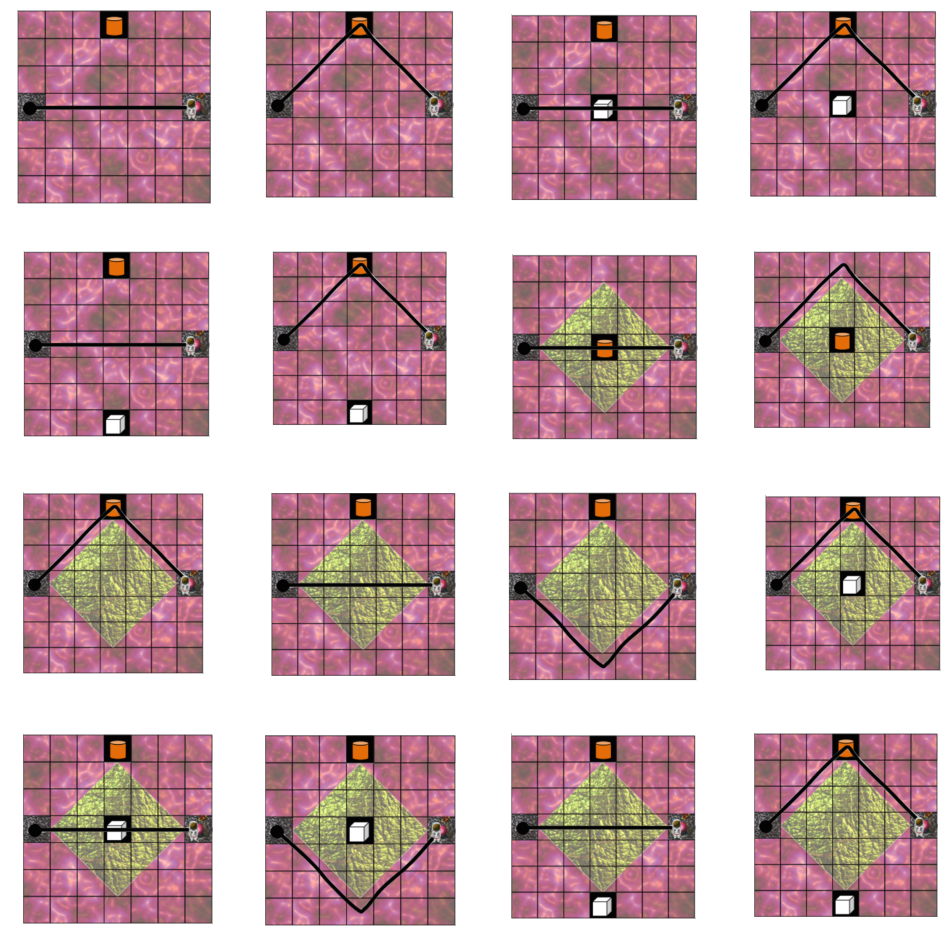

In [8]:
# Get example batch
directory = "images/naive_util_calc_images/Exp1a"
images = glob.glob(f'{directory}/*.png')
images = natsorted(images)

# Plot example batch
plt.figure(figsize=(12,12))
for i, seq in enumerate(images):
    image_pil = Image.open(seq)
    plt.subplot(4, 4, i+1)
    plt.imshow(image_pil)
    plt.axis("off")

In [9]:
# Set basic prompt that explains context
basic_prompt = "This task is about astronauts. The astronauts are exploring planets with alien terrains depicted with different colours and textures. Each astronaut has different skills, making each terrain more or less exhausting or easy for them to cross. All astronauts can ultimately cross all terrains, even if it's exhausting. The astronauts land far from the base and have to walk there. In each image, the black circle on the left indicates where the astronaut landed. The base is on the middle right part of the image. Sometimes care packages are dropped from above and the astronauts can pick them up. There are two kinds of care packages depicted with an orange cylinder and a white cube. Each astronaut has different preferences and likes each kind of care package in different amounts. The astronauts don't actually need the care packages. They can go straight to the base, or they can pick one up. You will see images of different astronauts with different skills and preferences travelling from their landing location to the home base. The astronauts always have a map. So they know all about the terrains and the care packages."
easy_basic_prompt = "The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or easy they are for the astronaut to cross. In some squares there is also an orange cylinder or a white cube in front of a black back ground. These objects may be rewarding for the astronaut and he might choose to pick them up if it is worth it for him. The astronauts don't actually need the objects. They can go straight to the final square, or they can pick one up. You will see images of different astronauts travelling from the center left square to the center right square. The astronauts always have a map. So they know all about the terrains and the objects."

### 1. Basic prompt plus number answer constraint

In [81]:
# Open the CSV file and create csv writer
with open(f"results/prompt_analysis/1_basic_number_fuyu.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    for i, seq in enumerate(images):

        # Load image
        image_pil = Image.open(seq).convert("RGB")


        # Set prompts for relevant experiment
        if i == 0 or i == 1:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]

        elif i == 2 or i == 3 or i == 4 or i == 5:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]

        elif i == 6 or i == 7 or i == 8 or i == 9 or i == 10:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]

        elif i == 11 or i == 12 or i == 13 or i == 14 or i == 15:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]
        
        for instruction in instructions:

            # Combine both prompts
            constraint = "Please answer the following question with a number only: "
            comb_instruction = basic_prompt + constraint + instruction

            # Pass input to model
            model_inputs = processor(text=comb_instruction, images=image_pil, return_tensors="pt").to("cuda:0")

            # Model output
            num_tokens = 3
            generation_output = model.generate(**model_inputs, max_new_tokens=num_tokens)
            response = processor.batch_decode(generation_output[:, -num_tokens:], skip_special_tokens=True)
            print(f"{seq}: {instruction} {response} \n")
            
            # Write a row to the CSV file
            writer.writerow([seq, constraint + instruction, response])
        
        # Cleaner output
        print("\n")

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['7'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['7'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['4'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['7'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





In [116]:
# Read output file
out = pd.read_csv(f"results/prompt_analysis/1_basic_number_fuyu.csv", header=None)
answers = out.loc[:,2]

# Re-format output
for row in range(len(answers)):
    answers[row] = answers[row].split("'")[1]
answers = answers.astype(float)

In [123]:
cost_corr = pearsonr(data["Human"][data["Type"] == "Cost"], answers[data["Type"] == "Cost"]).statistic
reward_corr = pearsonr(data["Human"][data["Type"] == "Reward"], answers[data["Type"] == "Reward"]).statistic
print(f"Basic prompt and single number response - Cost correlation: {cost_corr:.4f}, Reward correlation: {reward_corr:.4f}")

Basic prompt and single number response - Cost correlation: nan, Reward correlation: -0.2927


/tmp/ipykernel_3563982/1323643332.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cost_corr = pearsonr(data["Human"][data["Type"] == "Cost"], answers[data["Type"] == "Cost"]).statistic


### 2. Easy prompt plus number answer constraint

In [119]:
# Open the CSV file and create csv writer
with open(f"results/prompt_analysis/2_easy_number_fuyu.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    for i, seq in enumerate(images):

        # Load image
        image_pil = Image.open(seq).convert("RGB")


        # Set prompts for relevant experiment
        if i == 0 or i == 1:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]

        elif i == 2 or i == 3 or i == 4 or i == 5:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]

        elif i == 6 or i == 7 or i == 8 or i == 9 or i == 10:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]

        elif i == 11 or i == 12 or i == 13 or i == 14 or i == 15:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number!"]
        
        for instruction in instructions:

            # Combine both prompts
            constraint = "Please answer the following question with a number only: "
            comb_instruction = easy_basic_prompt + constraint + instruction

            # Pass input to model
            model_inputs = processor(text=comb_instruction, images=image_pil, return_tensors="pt").to("cuda:0")

            # Model output
            num_tokens = 3
            generation_output = model.generate(**model_inputs, max_new_tokens=num_tokens)
            response = processor.batch_decode(generation_output[:, -num_tokens:], skip_special_tokens=True)
            print(f"{seq}: {instruction} {response} \n")
            
            # Write a row to the CSV file
            writer.writerow([seq, constraint + instruction, response])
        
        # Cleaner output
        print("\n")

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['1'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['0'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['0'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['0'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['1'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['0'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['0'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['1'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['0'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? You are only allowed to answer with a number! ['0'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['10'] 



Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? You are only allowed to answer with a number! ['3'] 





In [126]:
# Read output file
out = pd.read_csv(f"results/prompt_analysis/2_easy_number_fuyu.csv", header=None)
answers = out.loc[:,2]

# Re-format output
for row in range(len(answers)):
    answers[row] = answers[row].split("'")[1]
answers = answers.astype(float)

In [127]:
cost_corr = pearsonr(data["Human"][data["Type"] == "Cost"], answers[data["Type"] == "Cost"]).statistic
reward_corr = pearsonr(data["Human"][data["Type"] == "Reward"], answers[data["Type"] == "Reward"]).statistic
print(f"Easy prompt and single number response - Cost correlation: {cost_corr:.4f}, Reward correlation: {reward_corr:.4f}")

Easy prompt and single number response - Cost correlation: 0.1316, Reward correlation: -0.1858


### 3. Basic prompt and chain of thought 

In [136]:
# Open the CSV file and create csv writer
with open(f"results/prompt_analysis/3_basic_cot_fuyu.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Loop through images
    for i, seq in enumerate(images):

        # Set prompts for relevant experiment
        if i == 0 or i == 1:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? "]

        elif i == 2 or i == 3 or i == 4 or i == 5:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? ",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? "]

        elif i == 6 or i == 7 or i == 8 or i == 9 or i == 10:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? "]

        elif i == 11 or i == 12 or i == 13 or i == 14 or i == 15:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)? ",
                            "How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)? "]
        
        for instruction in instructions:

            # Combine both prompts
            question_constraint = "Answer the following question and give your reasoning why: "
            answer_constraint = "Let's think step by step and then give your final answer as a single number in the format [X]."
            comb_instruction = basic_prompt + question_constraint + instruction + answer_constraint

            # Pass input to model
            model_inputs = processor(text=comb_instruction, images=image_pil, return_tensors="pt").to("cuda:0")

            # Model output
            num_tokens = 500
            generation_output = model.generate(**model_inputs, max_new_tokens=num_tokens)
            response = processor.batch_decode(generation_output[:, -num_tokens:], skip_special_tokens=False)
            print(f"{seq}: {instruction} {response} \n")
            
            # Write a row to the CSV file
            writer.writerow([seq, constraint + instruction, response])

        # Cleaner output
        print("\n")

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAK

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAK

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAK

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAK

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPE

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPE

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPE

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPE

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPE

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How much does the astronaut like the white care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEA

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How much does the astronaut like the orange care package on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPE

In [139]:
# Read output file
out = pd.read_csv(f"results/prompt_analysis/3_basic_cot_fuyu.csv", header=None)
answers = out.loc[:,2]

In [ ]:
cost_corr = pearsonr(data["Human"][data["Type"] == "Cost"], answers[data["Type"] == "Cost"]).statistic
reward_corr = pearsonr(data["Human"][data["Type"] == "Reward"], answers[data["Type"] == "Reward"]).statistic
print(f"Basic prompt and step by step - Cost correlation: {cost_corr:.4f}, Reward correlation: {reward_corr:.4f}")

### 4. Easy prompt and chain of thought

In [143]:
# Open the CSV file and create csv writer
with open(f"results/prompt_analysis/4_easy_cot_fuyu.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Loop through images
    for i, seq in enumerate(images):

        # Set prompts for relevant experiment
        if i == 0 or i == 1:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)? "]

        elif i == 2 or i == 3 or i == 4 or i == 5:
            instructions = ["How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)? ",
                            "How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)? "]

        elif i == 6 or i == 7 or i == 8 or i == 9 or i == 10:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)? "]

        elif i == 11 or i == 12 or i == 13 or i == 14 or i == 15:
            instructions = ["How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)? ",
                            "How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)? ",
                            "How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)? "]
        
        for instruction in instructions:

            # Combine both prompts
            question_constraint = "Answer the following question and give your reasoning why: "
            answer_constraint = "Let's think step by step and then give your final answer as a single number in the format [X]."
            comb_instruction = easy_basic_prompt + question_constraint + instruction + answer_constraint

            # Pass input to model
            model_inputs = processor(text=comb_instruction, images=image_pil, return_tensors="pt").to("cuda:0")

            # Model output
            num_tokens = 500
            generation_output = model.generate(**model_inputs, max_new_tokens=num_tokens)
            response = processor.batch_decode(generation_output[:, -num_tokens:], skip_special_tokens=False)
            print(f"{seq}: {instruction} {response} \n")
            
            # Write a row to the CSV file
            writer.writerow([seq, constraint + instruction, response])

        # Cleaner output
        print("\n")

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/0.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/1.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/2.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/3.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/4.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/5.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/6.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/7.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/8.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER|

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||S

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/9.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors 

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/10.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/11.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/12.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/13.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/14.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the yellow terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ['|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How easy is it for the astronaut to cross the pink terrain on a scale from 0 (extremely easy) to 10 (extremely exhausting)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How rewarding is the white object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors which relate to how hard or

Setting `pad_token_id` to `eos_token_id`:71013 for open-end generation.


images/naive_util_calc_images/Exp1a/15.png: How rewarding is the orange object for the astronaut on a scale from 0 (not at all) to 10 (a lot)?  ["|SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||SPEAKER||NEWLINE|<s> The image shows a grid of squares. The white figure on the center right square is the astronaut. Each square represents a single block of terrain that the astronaut can cross in one step. The astronaut moves along the black path that starts at the center left square and ends at the center right square. The squares have different colors

In [ ]:
# Read output file
out = pd.read_csv(f"results/prompt_analysis/4_easy_cot_fuyu.csv", header=None)
out = out.loc[:,2]

# Get only number if brackets
answers = np.zeros(out.shape[0])
for row in range(out.shape[0]):
    answers[row] = out[row].split("[")[1].split("]")[0]

In [ ]:
cost_corr = pearsonr(data["Human"][data["Type"] == "Cost"], answers[data["Type"] == "Cost"]).statistic
reward_corr = pearsonr(data["Human"][data["Type"] == "Reward"], answers[data["Type"] == "Reward"]).statistic
print(f"Easy prompt and step by step - Cost correlation: {cost_corr:.4f}, Reward correlation: {reward_corr:.4f}")